# Explaining Machine Learning

Interpretability of Machine Learning models has recently become a relevant 
 research direction to more thoroughly address and mitigate the issues of
 adversarial examples and to better understand the potential flows of the 
 most recent algorithm such as Deep Neural Networks.

In this tutorial, we explore different methods that SecML provides to compute 
 *post-hoc* explanations, which consist on analyzing a trained model to 
 understand which components such as features or training prototypes are
 more relevant during the decision (classification) phase.

## Feature-based explanations

Feature-based explanation methods assign a value to each feature of an input
 sample depending on how relevant it is towards the classification 
 decision. These relevance values are often called *attributions*.

In this tutorial, we are going to test the following *gradient-based* 
 explanation methods:

 - **Gradient**
 
  > [[baehrens2010explain]](http://www.jmlr.org/papers/volume11/baehrens10a/baehrens10a.pdf)
  > D. Baehrens, T. Schroeter, S. Harmeling, M. Kawanabe, K. Hansen,
  > K.-R.Muller, "How to explain individual classification decisions",
  > in: J. Mach. Learn. Res. 11 (2010) 1803-1831
 
 - **Gradient * Input**
 
  > [[shrikumar2016not]](https://arxiv.org/pdf/1605.01713)
  > A. Shrikumar, P. Greenside, A. Shcherbina, A. Kundaje,
  > "Not just a blackbox: Learning important features through propagating
  > activation differences", 2016 arXiv:1605.01713.

  > [[melis2018explaining]](https://arxiv.org/abs/1803.03544)
  > M. Melis, D. Maiorca, B. Biggio, G. Giacinto and F. Roli,
  > "Explaining Black-box Android Malware Detection," 2018 26th European 
  > Signal Processing Conference (EUSIPCO), Rome, 2018, pp. 524-528.

 - **Integrated Gradients**
 
  > [[sundararajan2017axiomatic]](https://arxiv.org/pdf/1703.01365)
  > Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic Attribution 
  > for Deep Networks." Proceedings of the 34th International Conference on 
  > Machine Learning, Volume 70, JMLR. org, 2017, pp. 3319-3328.

### Training of the classifier

First, we load the MSNIT dataset and we train an SVM classifier with RBF kernel.

In [1]:
random_state = 999

n_tr = 500  # Number of training set samples
n_ts = 500  # Number of test set samples

from secml.data.loader import CDataLoaderMNIST
loader = CDataLoaderMNIST()
tr = loader.load('training', num_samples=n_tr)
ts = loader.load('testing', num_samples=n_ts)

# Normalize the features in `[0, 1]`
tr.X /= 255
ts.X /= 255

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernel import CKernelRBF

clf = CClassifierMulticlassOVA( CClassifierSVM, kernel=CKernelRBF(gamma=1e-2))

print("Training of classifier...")
clf.fit(tr)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))


Training of classifier...
Accuracy on test set: 83.80%


### Compute the explanations

The `secml.explanation` package provides different explanation methods
 as subclasses of `CExplainer`. Each explainer requires as input a 
 trained classifier.

To compute the explanation on a sample, the `.explain()` method should be used.
For *gradient-based* methods, the label `y` of the class wrt the explanation
 should be computed is required.

The `.explain()` method will return the relevance value associated to each 
 feature of the input sample.

In [2]:
from secml.explanation import \
    CExplainerGradient, CExplainerGradientInput, CExplainerIntegratedGradients

explainers = (
    {
        'exp': CExplainerGradient(clf),  # Gradient
        'label': 'Gradient'
    },
    {
        'exp': CExplainerGradientInput(clf),  # Gradient * Input
        'label': 'Grad*Input'
    },
    {
        'exp': CExplainerIntegratedGradients(clf),  # Integrated Gradients
        'label': 'Int. Grads'
    },
)


In [3]:
i = 123  # Test sample on which explanations should be computed
x, y = ts[i, :].X, ts[i, :].Y

print("Explanations for sample {:} (true class: {:})".format(i, y.item()))

from secml.array import CArray

for expl in explainers:
    
    print("Computing explanations using '{:}'...".format(
        expl['exp'].__class__.__name__))
    
    # Compute explanations (attributions) wrt each class
    attr = CArray.empty(shape=(tr.num_classes, x.size))
    for c in tr.classes:
        
        attr_c = expl['exp'].explain(x, y=c)
        attr[c, :] = attr_c
        
    expl['attr'] = attr

Explanations for sample 123 (true class: 6)
Computing explanations using 'CExplainerGradient'...
Computing explanations using 'CExplainerGradientInput'...
Computing explanations using 'CExplainerIntegratedGradients'...


### Visualize results

We now visualize the explanations computed using the different methods, in rows.
In columns, we show the explanations wrt each different class.

Above the original tested sample, its true class label is shown.

Red (blue) pixels denote positive (negative) relevance of the corresponding
 feature wrt the specific class.

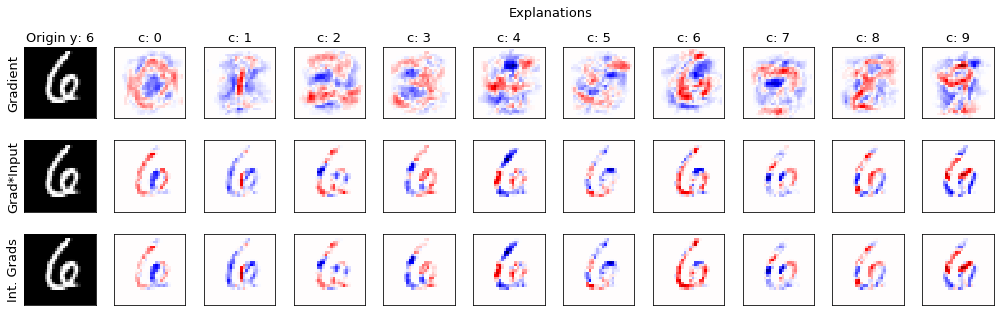

In [4]:
%matplotlib inline

from secml.figure import CFigure

fig = CFigure(height=4.5, width=14, fontsize=13)
        
for i, expl in enumerate(explainers):
    
    sp_idx = i * (tr.num_classes+1)
    
    # Original image
    fig.subplot(len(explainers), tr.num_classes+1, sp_idx+1)
    fig.sp.imshow(x.reshape((tr.header.img_h, tr.header.img_w)), cmap='gray')
    
    if i == 0:  # For the first row only
        fig.sp.title("Origin y: {:}".format(y.item()))
        
    fig.sp.ylabel(expl['label'])  # Label of the explainer
    
    fig.sp.yticks([])
    fig.sp.xticks([])
    
    # Threshold to plot positive and negative relevance values symmetrically
    th = max(abs(expl['attr'].min()), abs(expl['attr'].max()))
    
    # Plot explanations
    for c in tr.classes:
    
        fig.subplot(len(explainers), tr.num_classes+1, sp_idx+2+c)
        fig.sp.imshow(expl['attr'][c, :].reshape((tr.header.img_h, tr.header.img_w)),
                      cmap='seismic', vmin=-1*th, vmax=th)
        
        fig.sp.yticks([])
        fig.sp.xticks([])
        
        if i == 0:  # For the first row only
            fig.sp.title("c: {:}".format(c))

fig.title("Explanations", x=0.55)
fig.tight_layout(rect=[0, 0.003, 1, 0.94])
fig.show()

For both **gradient\*input** and **integrated gradients** methods we can 
 observe a well defined area of positive (red) relevance for the explanation 
 computed wrt the digit 6. This is expected as the true class of the tested 
 sample is in fact 6. Moreover, a non-zero relevance value is mainly assigned 
 to the features which are present in the tested sample, which is an expected 
 behavior of these explanation methods.
 
Conversely, the **gradient** method assigns relevance to a wider area of the 
 image, even external to the actual digit. This leads to explanations which
 are in many cases difficult to interpret. For this reason, more advanced
 explanation methods are often favored.

## Prototype-based explanation

Prototype-based explanation methods select specifc samples from the training 
dataset to explain the behavior of machine learning models.

In this tutorial, we are going to test the explanation method proposed in:

  > [[koh2017understanding]](https://arxiv.org/pdf/1703.04730)
  > Koh, Pang Wei, and Percy Liang, "Understanding black-box predictions
  > via influence functions", in: Proceedings of the 34th International
  > Conference on Machine Learning-Volume 70. JMLR. org, 2017.

### Training of the classifier

As our implementation of the prototype-based explanation methods currently 
 only supports binary classifiers, we load the 2-classes MNIST59 dataset and 
 then we train a SVM classifier with RBF kernel.

In [5]:
n_tr = 100  # Number of training set samples
n_ts = 500  # Number of test set samples

digits = (5, 9)

loader = CDataLoaderMNIST()
tr = loader.load('training', digits=digits, num_samples=n_tr)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Normalize the features in `[0, 1]`
tr.X /= 255
ts.X /= 255

clf = CClassifierSVM(kernel=CKernelRBF(gamma=1e-2))

print("Training of classifier...")
clf.fit(tr)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 96.20%


### Compute the influential training prototypes

The `CExplainerInfluenceFunctions` class provides the influence functions 
 prototype-based method described previously. It requires as input the 
 classifier to explain and its training set.
It also requires the identifier of the loss used to train the classier. In the 
 case of SVM, it is the `hinge` loss.

To compute the influence of each training sample wrt the test samples, 
 the `.explain()` method should be used.

In [6]:
from secml.explanation import CExplainerInfluenceFunctions

explanation = CExplainerInfluenceFunctions(
    clf, tr, outer_loss_idx='hinge')  # SVM loss is 'hinge'

print("Computing influence of each training prototype on test samples...")

infl = explanation.explain(ts.X, ts.Y)

print("Done.")

Computing influence of each training prototype on test samples...
Done.


### Visualize results

We now visualize, wrt each class, the 3 most influential training prototypes 
 for two different test samples. Above each training sample, the influence 
 value is shown.
 
In addition, above the original tested samples, the true class label is shown.

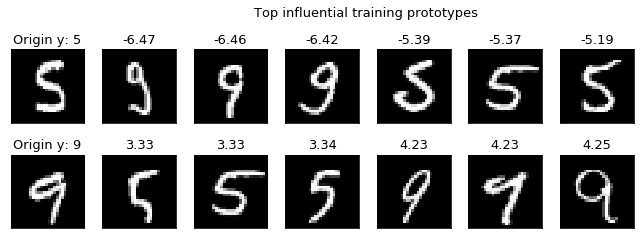

In [7]:
fig = CFigure(height=3.5, width=9, fontsize=13)
    
n_xc = 3  # Number of tr prototypes to plot per class

ts_list = (50, 100)  # Test samples to evaluate

infl_argsort = infl.argsort(axis=1)  # Sort influence values
        
for i, ts_idx in enumerate(ts_list):
    
    sp_idx = i * (n_xc*tr.num_classes+1)
    
    x, y = ts[ts_idx, :].X, ts[ts_idx, :].Y

    # Original image
    fig.subplot(len(ts_list), n_xc*tr.num_classes+1, sp_idx+1)
    fig.sp.imshow(x.reshape((tr.header.img_h, tr.header.img_w)), cmap='gray')
    
    fig.sp.title("Origin y: {:}".format(ts.header.y_original[y.item()]))
    
    fig.sp.yticks([])
    fig.sp.xticks([])
    
    tr_top = infl_argsort[ts_idx, :n_xc]
    tr_top = tr_top.append(infl_argsort[ts_idx, -n_xc:])
    
    # Plot top influential training prototypes
    for j, tr_idx in enumerate(tr_top):
        fig.subplot(len(ts_list), n_xc*tr.num_classes+1, sp_idx+2+j)
        fig.sp.imshow(tr.X[tr_idx, :].reshape((tr.header.img_h, tr.header.img_w)), cmap='gray')  
    
        fig.sp.title("{:.2f}".format(infl[ts_idx, tr_idx].item()))
    
        fig.sp.yticks([])
        fig.sp.xticks([])

fig.title("Top influential training prototypes", x=0.57)
fig.tight_layout(rect=[0, 0.003, 1, 0.92])
fig.show()

For both the tested samples we can observe a direct correspondence between 
 the most influencial training prototypes and their true class. Specifically, 
 the samples having highest (lowest) influence values are (are not) from 
 the same true class of the tested samples.